In [1]:
import tensorflow.keras as kr

In [2]:
import button_pos_script as btp
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import transform_data as trans

In [3]:
raw_data = btp.load_event('dataset1.csv')
raw_data = raw_data

In [4]:
def get_last(event):
    return event[event > 0].reshape(-1, 2)[-1]

def replace_with_last(event):
    return np.where(event == 0, get_last(event), event)

In [5]:
# Data Normalization

# data = np.copy(raw_data / [1280, 720])

def max_sample(event):
    as_pd = pd.DataFrame(event)
    uniques = as_pd.drop_duplicates()
    
    return np.array(uniques).shape[0]

def max_size(events):
    return np.max(np.array([max_sample(i) for i in events]))

data = raw_data[:, 0:max_size(raw_data), :]

datax = np.array([replace_with_last(i) for i in data])
# Transforms the data, duplicating the last position to the rest of the array

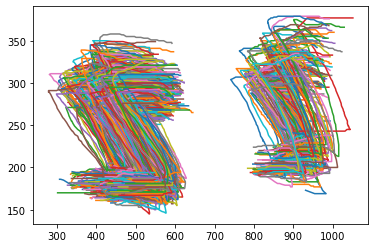

In [6]:
def sequence(m, n):
    li = []
    for i in range(len(m)-n+1):
        li.append(m[i:i+n])
    return np.array(li)

vectors = np.array([trans.ev_tovec(data, True, False)[1] for data in datax])

# [-1, -1] : 0
# [-1, 0] : 1
# [-1, 1] : 2
# [0, -1] : 3
# [0, 0] : 4
# [0, 1] : 5
# [1, -1] : 6
# [1, 0] : 7
# [1, 1] : 8

# train_x = sequence(vectors, 50)

In [7]:
vectors_n = np.true_divide((vectors.astype('float32') + [180, 0]), [360, 160])

In [8]:
chunks = 5

# flat_vec = vectors_n.reshape(-1, 2)

# seq = sequence(flat_vec, chunks)

# train_yy = flat_vec[chunks:]

train_xx = vectors_n[:, 0:144, :]
train_yy = vectors_n[:, 1:145, :]
# print(vectors_n.shape)
# train_x_split = train_x.reshape(-1, 4, 36, 2)
# train_x_split = train_y.reshape(-1, 4, 36, 2)
# train_xx = train_x_split[:, 0:2, :, :] 
# train_yy = train_xx = train_x_split[:, 2:, :, :]
print(train_xx.shape, train_yy.shape)
print(train_xx[0][-1], train_yy[0][0])

(796, 144, 2) (796, 144, 2)
[0.5 0. ] [0.5     0.01875]


In [9]:
# Model creation and training

model = kr.models.Sequential()
model.add(kr.layers.LSTM(30, input_shape=(None, 2), return_sequences=True))

model.add(kr.layers.LSTM(20, return_sequences=True, return_state=True))

model.add(kr.layers.TimeDistributed(kr.layers.Dense(2, activation='sigmoid')))

ValueError: All layers in a Sequential model should have a single output tensor. For multi-output layers, use the functional API.

In [459]:
opt = kr.optimizers.Adam(lr=0.001, decay=1e-5)
model.compile(loss='mse', optimizer=opt, metrics=[kr.metrics.mean_squared_error, 'accuracy'])
train_yy[6][0:1]

array([[0.42620819, 0.01397543]])

In [637]:
# learning Time
history = model.fit(train_xx, train_yy, validation_split=0.3, epochs=630, batch_size=45)

Train on 557 samples, validate on 239 samples
Epoch 1/630
557/557 [==============================] - 2s 4ms/sample - loss: 0.0013 - mean_squared_error: 0.0013 - accuracy: 1.0000 - val_loss: 0.0013 - val_mean_squared_error: 0.0013 - val_accuracy: 1.0000
Epoch 2/630
557/557 [==============================] - 2s 4ms/sample - loss: 0.0013 - mean_squared_error: 0.0013 - accuracy: 1.0000 - val_loss: 0.0013 - val_mean_squared_error: 0.0013 - val_accuracy: 1.0000
Epoch 3/630
557/557 [==============================] - 2s 4ms/sample - loss: 0.0013 - mean_squared_error: 0.0013 - accuracy: 1.0000 - val_loss: 0.0013 - val_mean_squared_error: 0.0013 - val_accuracy: 1.0000
Epoch 4/630
557/557 [==============================] - 1s 2ms/sample - loss: 0.0013 - mean_squared_error: 0.0013 - accuracy: 1.0000 - val_loss: 0.0013 - val_mean_squared_error: 0.0013 - val_accuracy: 1.0000
Epoch 5/630
557/557 [==============================] - 1s 2ms/sample - loss: 0.0013 - mean_squared_error: 0.0013 - accuracy: 1

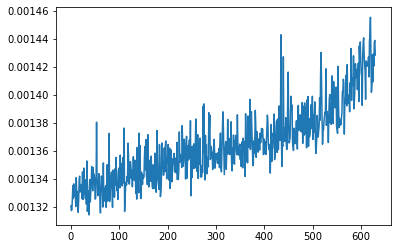

In [650]:
plt.plot(history.history["val_mean_squared_error"])
model.save('best_model1000.h5')

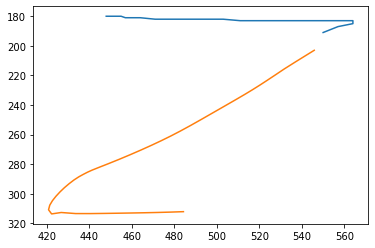

In [649]:
def get_nextpos(coord, direct):
        next_pos = coord + [0, np.sin(direct[0] * np.pi / 180) * direct[1]]
        next_pos = next_pos + [np.cos(direct[0] * np.pi / 180) * direct[1], 0]
        return next_pos

def trayectory(directions, initial_point):
    denormalized = directions * [360, 160] - [180, 0]
    # print(denormalized)
    li = []
    # print(denormalized[0])
    nexti = initial_point
    li.append(nexti)
    for i in range(len(denormalized)):
        nexti = get_nextpos(nexti, denormalized[i])
        # print(nexti)
        li.append(nexti.tolist())
    
    return np.array(li)

# print(train_xx[603].shape)
# prediction = model.predict(np.array([train_xx[601]]))
# datax_n = datax[600][31]
# print(datax_n)
# # print(train_yy[0])
# trans.plot_events(datax[600][15:30])
# print(prediction)
# result = trayectory(prediction[0], datax_n)
# trans.plot_events(result)
event = 630



li = []
current = train_xx[event][0:26]
current_d = datax[event]
trans.plot_events(datax[event][0:26])
for i in range(45):
    prediction = model.predict(np.expand_dims(current, axis=0))
    datax_n = current_d[1]
    # trans.plot_events(datax[600][0:10])
    results = trayectory(prediction[0], datax_n)
    li.append(results[-1])

    # [current] + [last_update] : (x, y)
    # join = np.concatenate((datax[event][0], results[1:]))
    current_d = np.concatenate((current_d[0:26+i+1], np.expand_dims(results[-1], axis=0)), axis=0)
    current_asvec = trans.ev_tovec(current_d, False, False)[1]
    current_asvec = np.true_divide((current_asvec.astype('float32') + [180, 0]), [360, 160])
    
    # print(current_asvec[1:], prediction[0][-1])
    current = np.concatenate((current_asvec, np.expand_dims(prediction[0][-1], axis=0)), axis=0)
    # print(current[-1])

liarray = np.array(li)

final = np.concatenate((np.expand_dims(datax[event][1], axis=0), liarray))
# rint(final[0:2])
result = trans.ev_tovec(liarray, True, False)

In [598]:
model.save('best_model.h5')

(1, 144, 2)
predict [[0. 3.]
 [0. 2.]
 [0. 2.]]
size predict 9
denormalize [[[-78.43319893  -2.44285092]
  [-23.99583578   4.62884177]
  [  7.66603231   8.44091412]
  [ 18.92043114   9.01864246]
  [ 17.17633009   7.66258832]
  [  9.81252909   5.7984411 ]
  [  1.79813147   4.26914882]
  [ -4.24527168   3.38884506]
  [ -7.51285672   3.15365605]]] 1
lcurrent [927 180]
current 10
current 10
predict after iteration 9
predict [[ 0.          2.        ]
 [ 0.          2.        ]
 [-7.51285672  3.15365605]]
size predict 9
denormalize [[[-78.43319893  -2.44285092]
  [-23.99583578   4.62884177]
  [  7.75600433   8.45449407]
  [ 18.97484779   9.02905349]
  [ 17.18147993   7.66582437]
  [  9.71734285   5.77919461]
  [  1.68798923   4.2401774 ]
  [ -4.29932356   3.36609401]
  [ -9.53429818   3.09676163]]] 1
lcurrent [930.12658364 179.58766369]
current 10
current 10
predict after iteration 9
predict [[ 0.          2.        ]
 [-7.51285672  3.15365605]
 [-9.53429818  3.09676163]]
size predict 9
den

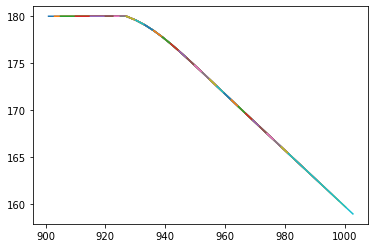

In [205]:
def get_nextpos(coord, direct):
        next_pos = coord + [0, np.sin(direct[0] * np.pi / 180) * direct[1]]
        next_pos = next_pos + [np.cos(direct[0] * np.pi / 180) * direct[1], 0]
        return next_pos

prediction = model.predict(np.array([train_xx[3]]))

print(prediction.shape)
def trayetory(directions, initial_point):
    denormalized = directions * [360, 1060] - [180, 0]
    li = []
    nexti = initial_point
    for i in range(len(denormalized)):
        nexti = get_nextpos(nexti, denormalized[i])
        li.append(nexti)
    
    return np.array(li)

def prediction(model, initial, amount):
    vecs = []
    current_asvec = []
    current = initial
    predict = trans.ev_tovec(current, False, False)[1]
    vecs = initial

    for _ in range(amount):
        predict_n = (predict + [180, 0]) / [360, 1060]
        print('predict' , predict[-3:])
        print('size predict', predict_n.shape[0])
        result = model.predict(np.array([predict_n]))
        # print('result', result)
        denormalize = result * [360, 1060] - [180, 0]
        print('denormalize', denormalize, denormalize.shape[0])
        val = denormalize[0][-1]
        print('lcurrent', current[-1])
        next_pos = get_nextpos(current[-1], val)
        # print('next_pos', next_pos)
        vecs = np.concatenate((vecs, np.expand_dims(next_pos, 0)), axis=0)
        print('current', current.shape[0])
        current = btp.ev_stack(current[1:], np.array([next_pos]))
        print('current', current.shape[0])
        current_asvec = trans.ev_tovec(np.array(current), True, False)[1]
        predict = current_asvec
        # predict = btp.ev_stack(predict[1:], next_value)
        print('predict after iteration', predict.shape[0])
    return np.array(vecs)

datax_n = datax[0:26]

predict = prediction(model, datax_n[1][0:0+10], 30)
print(predict)

predict [[ 3.81407483 15.03329638]
 [26.56505118  4.47213595]
 [ 6.34019175  9.05538514]]
size predict 5
denormalize [[9.63020325 6.42720284]] 1
lcurrent [929 217]
current 6
current 6
predict after iteration 5
predict [[26.56505118  4.47213595]
 [ 6.34019175  9.05538514]
 [ 9.63020325  6.42720284]]
size predict 5
denormalize [[11.69672728  5.97835371]] 1
lcurrent [935.33663062 218.07519704]
current 6
current 6
predict after iteration 5
predict [[ 6.34019175  9.05538514]
 [ 9.63020325  6.42720284]
 [11.69672728  5.97835371]]
size predict 5
denormalize [[9.95723963 5.44109868]] 1
lcurrent [941.19084019 219.28719683]
current 6
current 6
predict after iteration 5
predict [[ 9.63020325  6.42720284]
 [11.69672728  5.97835371]
 [ 9.95723963  5.44109868]]
size predict 5
denormalize [[9.02868032 5.10691898]] 1
lcurrent [946.54998    220.22803439]
current 6
current 6
predict after iteration 5
predict [[11.69672728  5.97835371]
 [ 9.95723963  5.44109868]
 [ 9.02868032  5.10691898]]
size predict 5

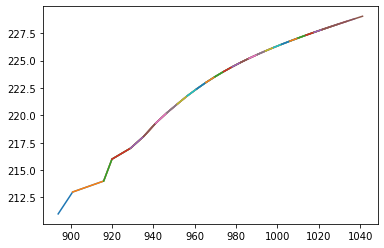

In [202]:
def get_nextpos(coord, direct):
        next_pos = coord + [0, np.sin(direct[0] * np.pi / 180) * direct[1]]
        next_pos = next_pos + [np.cos(direct[0] * np.pi / 180) * direct[1], 0]
        return next_pos

def prediction(model, initial, amount):
    vecs = []
    current_asvec = []
    current = initial
    predict = trans.ev_tovec(current, False, False)[1]

    for _ in range(amount):
        predict_n = (predict + [180, 0]) / [360, 1060]
        print('predict' , predict[-3:])
        print('size predict', predict_n.shape[0])
        result = model.predict(np.array([predict_n]))
        # print('result', result)
        denormalize = result * [360, 1060] - [180, 0]
        print('denormalize', denormalize, denormalize.shape[0])
        val = denormalize[0]
        print('lcurrent', current[-1])
        next_pos = get_nextpos(current[-1], val)
        # print('next_pos', next_pos)
        vecs.append(next_pos)
        print('current', current.shape[0])
        current = btp.ev_stack(current[1:], np.array([next_pos]))
        print('current', current.shape[0])
        current_asvec = trans.ev_tovec(np.array(current), True, False)[1]
        predict = current_asvec
        # predict = btp.ev_stack(predict[1:], next_value)
        print('predict after iteration', predict.shape[0])
    return np.array(vecs)
    
    # asnp = np.array(vecs)
    # print(asnp.shape)
    # return np.reshape(asnp, (asnp.shape[0], asnp.shape[2]))

datax_n = datax[0:26]

predict = prediction(model, datax_n[10][0:0+6], 26)

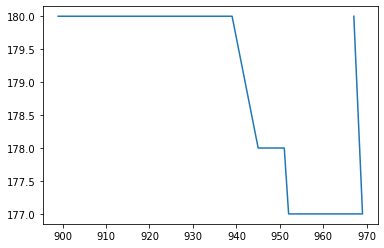

In [118]:
trans.plot_events(datax_n[1][0:0+29])

[[905.2429274  247.98228018]
 [898.09296006 252.09605645]
 [892.64699725 254.71790358]
 [887.03330021 256.91702093]
 [879.77066731 259.18653948]
 [869.951247   261.58645835]
 [857.87620978 263.73647707]
 [843.87619428 265.36093406]
 [828.79439824 266.18504572]
 [813.38590019 266.11283202]
 [820.97998999 285.2711726 ]
 [843.98012498 299.22621104]
 [888.11851247 311.49063113]
 [946.40534731 328.83524812]]


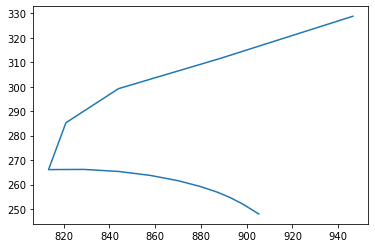

In [119]:
print(predict)
trans.plot_events(predict)

In [74]:
model2 = kr.models.load_model('working.h5')

In [75]:
model2.fit(train_xx, train_yy)

Train on 4571 samples
4571/4571 [==============================] - 24s 5ms/sample - loss: 0.0015 - accuracy: 1.0000


In [77]:
model2.predict(np.array([datax_n[7][0:0+30]]))

array([[0.2900195, 0.4545153]], dtype=float32)